In [ ]:
# Uncomment if on Google Colab
# !pip install jaxkd

# And change runtime type to GPU!

In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr

import jaxkd as jk
from scipy.spatial import KDTree

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

key = jr.key(83)

## Visualization

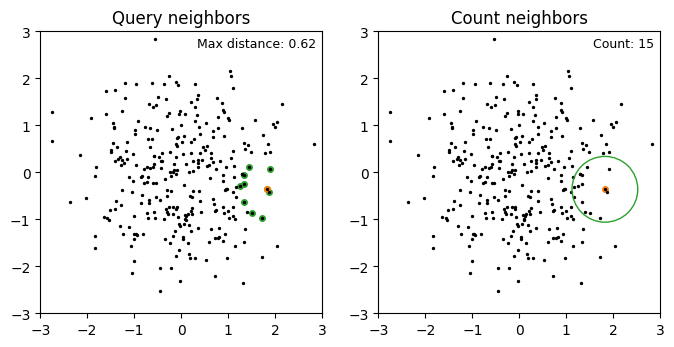

In [3]:
# Query and count neighbors on random 2d points
n_points = 300
n_neighbors = 10
count_radius = 0.7

key, subkey = jr.split(key)
points = jr.normal(subkey, shape=(n_points, 2))
tree = jk.build_tree(points)
counts = jk.count_neighbors(tree, points[0], r=count_radius)
neighbors, distances = jk.query_neighbors(tree, points[0], k=n_neighbors)

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
for ax in axes:
    ax.scatter(*points[0], s=16, c='C1')
    ax.scatter(*points.T, s=2, c='k')
    ax.set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
axes[0].set(title='Query neighbors')
axes[0].scatter(*points[neighbors].T, s=16, c='C2', zorder=-1)
axes[0].text(0.98, 0.98, f'Max distance: {jnp.max(distances):.2f}', fontsize=9, ha='right', va='top', color='k', transform=axes[0].transAxes)
axes[1].set(title='Count neighbors')
axes[1].add_artist(plt.Circle(points[0], count_radius, color='C2', fill=False))
axes[1].text(0.98, 0.98, f'Count: {counts}', fontsize=9, ha='right', va='top', color='k', transform=axes[1].transAxes)
plt.show()

## Gradients

The simplest way to use the tree would be to keep the points fixed and optimize some function over neighbors. It might be convenient to have everything in JAX, but fundamentally this would be just as easy with a static neighbor array built using `scipy.spatial.KDTree`.

A more fun way to use the tree is to allow points to move and dynamically update the neighbors at every step of the optimization. The entire loop can be JIT-compiled and run on the GPU!

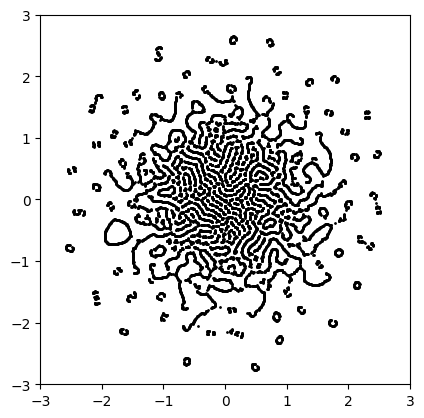

In [ ]:
# Nearest neighbors at fixed distances -- the result depends strongly on k, the distance scale, and the number of points!
def loss_func(points):
    tree = jk.build_tree(points)
    neighbors, _ = jk.query_neighbors(tree, points, k=25)
    distances = jnp.linalg.norm(points[:,None] - points[neighbors][:,1:], axis=-1) # recompute without self-distance for finite gradient
    return jnp.sum(jnp.square(distances - 0.005 * jnp.arange(neighbors.shape[-1])[1:]))

@jax.jit
def step(points, _):
    loss, grad = jax.value_and_grad(loss_func)(points)
    points = points - 0.01 * grad
    return points, (points, loss)

# Optimize location of random initial points
n_points = 10_000
key, subkey = jr.split(key)
points = jr.normal(subkey, shape=(n_points, 2))
points, (points_hist, loss_hist) = jax.lax.scan(step, points, None, length=50)

# Plot
plt.scatter(*points.T, s=1, c='k')
plt.gca().set(xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
plt.show()

In [ ]:
# Animate the optimization, points arrange themselves on lines with equal spacing
fig, ax = plt.subplots(figsize=(5, 5))
s = ax.scatter(*points_hist[0].T, s=1, c='k')
ax.set(xlim=(-3, 3), ylim=(-3, 3))
def update(i):
    s.set_offsets(points_hist[i])
    return s,
ani = FuncAnimation(fig, update, frames=range(0, len(points_hist)), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Clustering

The ability to dynamically build a tree within JIT also enables us to write iterative algorithms like $k$-means easily. We just have to use `segment_sum` to compute the mean with a variable number of points per cluster. This is also implemented in `jaxkd.extras`.

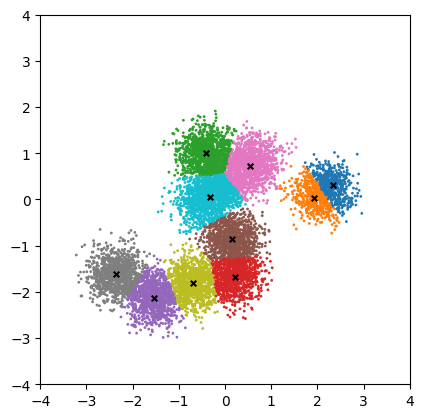

In [ ]:
# Make mock cluster data
n_clusters = 10
n_points_per_cluster = 1_000
key, *subkeys = jr.split(key, 4)
points = (
    jr.normal(subkeys[0], shape=(n_clusters, 2)) # cluster center
    + 0.3 * jr.normal(subkeys[1], shape=(n_points_per_cluster, n_clusters, 2)) # cluster spread
).reshape(-1, 2)
initial_centroids = jr.choice(subkeys[2], points, shape=(n_clusters,)) # initial means

# Run a few k-means iterations
n_iterations = 50
def k_means_step(centroids, _):
    tree = jk.build_tree(centroids)
    nearest_centroid = jk.query_neighbors(tree, points, k=1)[0].squeeze(-1)
    total = jax.ops.segment_sum(points, nearest_centroid, len(centroids))
    count = jax.ops.segment_sum(jnp.ones_like(points), nearest_centroid, len(centroids))
    centroids = total / count
    return centroids, (centroids, nearest_centroid)
centroids, (centroid_hist, cluster_hist) = jax.lax.scan(k_means_step, initial_centroids, length=50)

# Plot the result
plt.scatter(*points.T, c=cluster_hist[-1], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
plt.scatter(*centroids.T, c='k', s=16, marker='x')
plt.gca().set(xlim=(-4, 4), ylim=(-4, 4), aspect='equal')
plt.show()

In [ ]:
# Animate k-means iterations
fig, ax = plt.subplots(figsize=(5, 5))
s1 = ax.scatter(*points.T, c=cluster_hist[0], s=1, cmap='tab20', vmin=0, vmax=n_clusters)
s2 = ax.scatter(*centroids.T, c='k', s=16, marker='x')
ax.set(xlim=(-4, 4), ylim=(-4, 4))
def update(i):
    s1.set_array(cluster_hist[i])
    s2.set_offsets(centroid_hist[i])
    return s1, s2
ani = FuncAnimation(fig, update, frames=range(0, n_iterations), interval=1000/10, blit=True)
plt.close()
HTML(ani.to_jshtml())

## Scale to more points

For large numbers of points, it is *highly* recommended to run on GPU. Operations are automatically compiled, so run a second time to see the compiled speed. Obviously an XLA-based tree code is not the answer if performance is the only factor, but it should be fast enough to be usable where JAX compatibility is important.

In [ ]:
# Sample points
n_points = 1_000_000
n_queries = 1_000_000
key, *subkey = jr.split(key, 3)
points = jr.normal(subkey[0], shape=(n_points, 3))
queries = jr.normal(subkey[1], shape=(n_queries, 3))

In [9]:
# Build tree and find neighbors
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, queries, k=4)
neighbors

Array([[910954, 264841, 633802, 474642],
       [869272, 664406, 913577,  35341],
       [770480, 569414, 732603, 651885],
       ...,
       [260343, 343420, 854462, 141338],
       [864119, 786538, 808474, 461141],
       [ 70590, 956063, 905014, 710215]], dtype=int32)

In [10]:
# Build scipy KDTree to compare
scipy_tree = KDTree(points)
scipy_neighbors = scipy_tree.query(queries, k=4, workers=-1)[1]
scipy_neighbors

array([[910954, 264841, 633802, 474642],
       [869272, 664406, 913577,  35341],
       [770480, 569414, 732603, 651885],
       ...,
       [260343, 343420, 854462, 141338],
       [864119, 786538, 808474, 461141],
       [ 70590, 956063, 905014, 710215]], shape=(1000000, 4))

In [11]:
# Do all points match? Sometimes floating point errors seem to cause a tiny difference
jnp.sum(neighbors == scipy_neighbors) / neighbors.size

Array(1., dtype=float32)

## Advanced: calling cudaKDTree

If neighbor search is the computational bottleneck and performance is critical, it may be worth it to bind the lower-level [cudaKDTree](https://github.com/ingowald/cudaKDTree) library to JAX. We provide a simple example of this in `jaxkd.cukd`, inspired by [this repo](https://github.com/EiffL/JaxKDTree/tree/main) and updated to work with the new JAX FFI API. You will need to build the bindings from source yourself, but if everything goes well it will be as simple as running the three command below. This will require CMake and the CUDA Toolkit.

In [ ]:
# First, restart the kernel! (In Google Colab, Runtime -> Restart session)

In [ ]:
# Clone the repository (bindings do not come with PyPI package)
# !git clone https://github.com/dodgebc/jaxkd.git --recurse-submodules
# %cd jaxkd

# Run the following commands to build the bindings from source (assumes CMake, CUDA Toolkit)
# !cmake -S external -B external/build
# !cmake --build external/build
# !cp external/build/libjaxcukd*.so jaxkd/

# Then we have to install the package from the local copy
# !pip install .

In [ ]:
# Sample points
n_points = 1_000_000
n_queries = 1_000_000
key, *subkey = jr.split(key, 3)
points = jr.normal(subkey[0], shape=(n_points, 3))
queries = jr.normal(subkey[1], shape=(n_queries, 3))

In [14]:
# Build tree and find neighbors
tree = jk.build_tree(points)
neighbors, distances = jk.query_neighbors(tree, queries, k=4)
neighbors

Array([[387963, 156636, 340126, 575166],
       [422222, 405242, 987804, 964845],
       [332833, 746318, 403543,  74627],
       ...,
       [217822, 553815, 406425, 973562],
       [ 10516, 428809, 674138, 417872],
       [229445, 624476, 232243, 233238]], dtype=int32)

In [15]:
# Now with cukd to compare
jk.cukd.init()
cukd_neighbors, _ = jk.cukd.query_neighbors(points, queries, k=4)
cukd_neighbors

Array([[387963, 156636, 340126, 575166],
       [422222, 405242, 987804, 964845],
       [332833, 746318, 403543,  74627],
       ...,
       [217822, 553815, 406425, 973562],
       [ 10516, 428809, 674138, 417872],
       [229445, 624476, 232243, 233238]], dtype=int32)

In [16]:
# Do all points match? Sometimes floating point errors seem to cause a tiny difference
jnp.sum(neighbors == cukd_neighbors) / neighbors.size

Array(1., dtype=float32)